# 1. Mean and Median For Every Three Months

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#call the csv to dataframe
df = pd.read_csv(r'Downloads\Pivot_Table_Electric_Production.csv')

#replace string in the date column
df['Year Quarter'] = df['Year Quarter'].str.replace('Q1','01-01')
df['Year Quarter'] = df['Year Quarter'].str.replace('Q2','04-01')
df['Year Quarter'] = df['Year Quarter'].str.replace('Q3','07-01')
df['Year Quarter'] = df['Year Quarter'].str.replace('Q4','09-01')

#change string to date format
df['Year Quarter'] = pd.to_datetime(df['Year Quarter'])
df

,Year Quarter,Mean of Electric Production,Median of Electric Production
0,1985-01-01,68.5425,70.6720
1,1985-04-01,56.9590,57.4714
2,1985-07-01,62.1511,62.6202
3,1985-09-01,61.0101,58.0005
4,1986-01-01,67.8382,67.9869
...,...,...,...
128,2017-01-01,105.1267,101.0396
129,2017-04-01,94.1956,92.0805
130,2017-07-01,106.5668,108.9312
131,2017-09-01,101.8903,97.3359


In [2]:
#change the year to be index
df.set_index('Year Quarter',inplace=True)

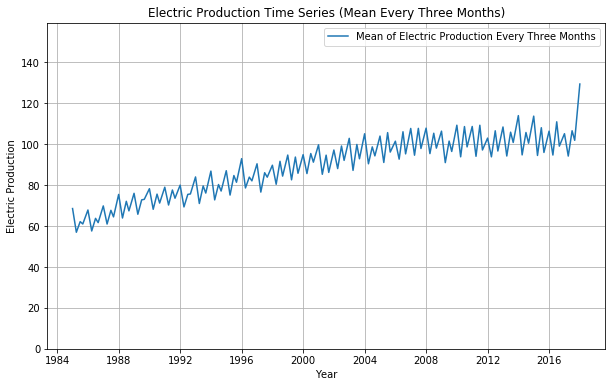

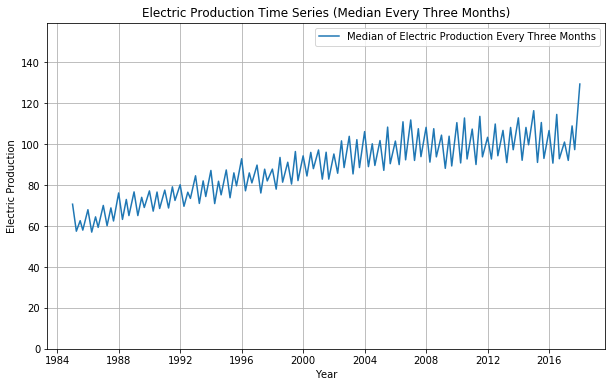

In [3]:
#plot the time series from Mean data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Mean of Electric Production'], label='Mean of Electric Production Every Three Months')

plt.ylim(0, max(df['Mean of Electric Production'])+30) #the y axis should start from 0

plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Electric Production Time Series (Mean Every Three Months)')
plt.legend()
plt.grid(True)
plt.show()

#plot the time series from Median data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Median of Electric Production'], label='Median of Electric Production Every Three Months')

plt.ylim(0, max(df['Median of Electric Production'])+30)

plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Electric Production Time Series (Median Every Three Months)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Stationary test

#### First, determine the p-value
#### If the p-value<0.05, we reject H0, means 'The time series is stationary'
#### If the p-value>0.05, we fail to reject H0, means 'The time series is not stationary'

In [4]:
#Stationary test for mean data
print('Stationary test for mean data')
time_series = df['Mean of Electric Production']
#ADF test
result = adfuller(time_series)
p_value = result[1]
print("p-value:", p_value)
#Check the p-value against a significance level (e.g., 0.05) to make a decision
if p_value <= 0.05:
    print("The time series is stationary (reject H0).")
else:
    print("The time series is non-stationary (fail to reject H0).")

    
#Stationary test for median data
print('Stationary test for median data')
time_series = df['Median of Electric Production']
#ADF test
result = adfuller(time_series)
p_value = result[1]
print("p-value:", p_value)
#Check the p-value against a significance level (e.g., 0.05) to make a decision
if p_value <= 0.05:
    print("The time series is stationary (reject H0).")
else:
    print("The time series is non-stationary (fail to reject H0).")

Stationary test for mean data
p-value: 0.010744380138396811
The time series is stationary (reject H0).
Stationary test for median data
p-value: 0.025118743593809674
The time series is stationary (reject H0).


#### The data is stationary, so we can continue to do forecasting

# 3. Forecasting

#### First, determine which model should be used by seeing the smallest RMSE. The options of model are ARIMA, ARMA, and MA.

In [5]:
time_series = df['Mean of Electric Production'].values
n_steps = 10

#ARIMA Model
p, d, q = 1, 1, 1
arima_model = ARIMA(time_series, order=(p, d, q))
arima_result = arima_model.fit()
#Make forecasts for 'n' steps ahead
forecast_values = arima_result.forecast(steps=n_steps)
#Actual values for the next 'n' steps
actual_values = df['Mean of Electric Production'].iloc[-n_steps:]
#Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
print("RMSE ARIMA Model: ", rmse)

#ARMA model
p, q = 1, 1
arma_model = ARIMA(time_series, order=(p, 0, q))
arma_result = arma_model.fit()
#Make forecasts for 'n' steps ahead
forecast_values = arma_result.forecast(steps=n_steps)
#Actual values for the next 'n' steps
actual_values = df['Mean of Electric Production'].iloc[-n_steps:]
#Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
print("RMSE ARMA Model: ", rmse)

#MA Model
time_series = df['Mean of Electric Production']
#Specify the size of the moving average window
window_size = 3
#Calculate the moving average
moving_average = time_series.rolling(window=window_size).mean()
#Remove NaN values from the moving average (due to window size)
moving_average = moving_average.dropna()
#Actual values for the same period as the moving average
actual_values = time_series[2:]
#Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, moving_average))
print("RMSE MA Model:", rmse)

RMSE ARIMA Model:  20.06012630106035
RMSE ARMA Model:  10.294734842533138
RMSE MA Model: 4.228275975288996


In [6]:
time_series = df['Mean of Electric Production'].values

# Fit MA model with order (0, 1)
q = 1
ma_model = ARIMA(time_series, order=(0, 0, q))
ma_result = ma_model.fit()

# View the summary of the MA model
print(ma_result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  133
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -528.162
Date:                Fri, 28 Jul 2023   AIC                           1062.324
Time:                        15:53:23   BIC                           1070.995
Sample:                             0   HQIC                          1065.848
                                - 133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.1146      1.850     48.176      0.000      85.489      92.740
ma.L1          0.3283      0.160      2.046      0.041       0.014       0.643
sigma2       164.6049     23.929      6.879      0.0

#### We use MA Model since it gives the smallest RMSE

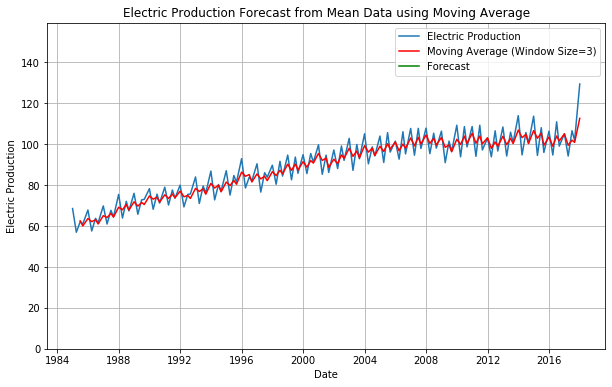

Forecast Electric Production Based on Mean Data for 2018-07-01 is 112.62063333333333


In [7]:
time_series = df['Mean of Electric Production']

#Specify the size of the moving average window
window_size = 3

#Calculate the moving average
moving_average = time_series.rolling(window=window_size).mean()

#Forecasting 'n' steps ahead using the last moving average value
n_steps = 2
forecast_values = [moving_average.iloc[-1]] * n_steps

#Plotting the original data, moving average, and forecast
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Electric Production')
plt.plot(moving_average, label=f'Moving Average (Window Size={window_size})', color='red')
forecast_index = pd.date_range(start=time_series.index[-1], periods=n_steps+1, closed='right')
plt.plot(forecast_index[0:], forecast_values, label='Forecast', color='green')
plt.ylim(0, max(df['Mean of Electric Production'])+30)
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.title('Electric Production Forecast from Mean Data using Moving Average')
plt.legend()
plt.grid(True)
plt.show()

print('Forecast Electric Production Based on Mean Data for 2018-07-01 is',forecast_values[1])

In [8]:
time_series = df['Median of Electric Production'].values
n_steps = 10

#ARIMA Model
p, d, q = 1, 1, 1
arima_model = ARIMA(time_series, order=(p, d, q))
arima_result = arima_model.fit()
#Make forecasts for 'n' steps ahead
forecast_values = arima_result.forecast(steps=n_steps)
#Actual values for the next 'n' steps
actual_values = df['Median of Electric Production'].iloc[-n_steps:]
#Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
print("RMSE ARIMA Model: ", rmse)

#ARMA model
p, q = 1, 1
arma_model = ARIMA(time_series, order=(p, 0, q))
arma_result = arma_model.fit()
#Make forecasts for 'n' steps ahead
forecast_values = arma_result.forecast(steps=n_steps)
#Actual values for the next 'n' steps
actual_values = df['Median of Electric Production'].iloc[-n_steps:]
#Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
print("RMSE ARMA Model: ", rmse)

#MA Model
time_series = df['Median of Electric Production']
#Specify the size of the moving average window
window_size = 3
#Calculate the moving average
moving_average = time_series.rolling(window=window_size).mean()
#Remove NaN values from the moving average (due to window size)
moving_average = moving_average.dropna()
#Actual values for the same period as the moving average
actual_values = time_series[2:]
#Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, moving_average))
print("RMSE MA Model:", rmse)

RMSE ARIMA Model:  19.453133908011733
RMSE ARMA Model:  11.97726710911835
RMSE MA Model: 5.184963980239234


In [9]:
time_series = df['Median of Electric Production'].values

# Fit MA model with order (0, 1)
q = 1
ma_model = ARIMA(time_series, order=(0, 0, q))
ma_result = ma_model.fit()

# View the summary of the MA model
print(ma_result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  133
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -540.757
Date:                Fri, 28 Jul 2023   AIC                           1087.515
Time:                        15:53:24   BIC                           1096.186
Sample:                             0   HQIC                          1091.038
                                - 133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.2673      2.085     42.326      0.000      84.180      92.355
ma.L1          0.2202      0.184      1.197      0.231      -0.140       0.581
sigma2       199.0280     30.758      6.471      0.0

#### We use MA Model since it gives the smallest RMSE

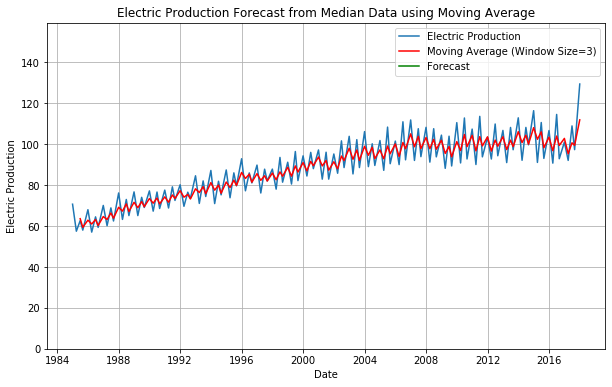

Forecast Electric Production Based on Median Data for 2018-07-01 is 111.89063333333333


In [10]:
time_series = df['Median of Electric Production']

#Specify the size of the moving average window
window_size = 3

#Calculate the moving average
moving_average = time_series.rolling(window=window_size).mean()

#Forecasting 'n' steps ahead using the last moving average value
n_steps = 2
forecast_values = [moving_average.iloc[-1]] * n_steps

#Plotting the original data, moving average, and forecast
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Electric Production')
plt.plot(moving_average, label=f'Moving Average (Window Size={window_size})', color='red')
forecast_index = pd.date_range(start=time_series.index[-1], periods=n_steps+1, closed='right')
plt.plot(forecast_index[0:], forecast_values, label='Forecast', color='green')
plt.ylim(0, max(df['Median of Electric Production'])+30)
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.title('Electric Production Forecast from Median Data using Moving Average')
plt.legend()
plt.grid(True)
plt.show()

print('Forecast Electric Production Based on Median Data for 2018-07-01 is',forecast_values[1])